## Ploting random spectrum with generated and predicted peaks

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

Ranges of parameters in units and constants used in experiment.

In [2]:
sp_min, sp_max = -10., 10.
fr_min, fr_max = 0., 256.
dc_min, dc_max = 0.1, 10.
am_min, am_max = 0.1, 5.

series = 20
dwmin, dwmax = -10., 10.

Number of pixels and cells along the speed and frequency dimension.

In [3]:
sp_pixels, fr_pixels = 256, 256
sp_cells, fr_cells = 16, 16

Offsets of cells relative to the entire grid in range from 0 to number of cells.

In [5]:
fr_offsets, sp_offsets = tf.meshgrid(tf.range(fr_cells, dtype = tf.float32),
                                     tf.range(sp_cells, dtype = tf.float32))

### Model
Takes a spectrum and returns objectness and peak shifts on the grid.

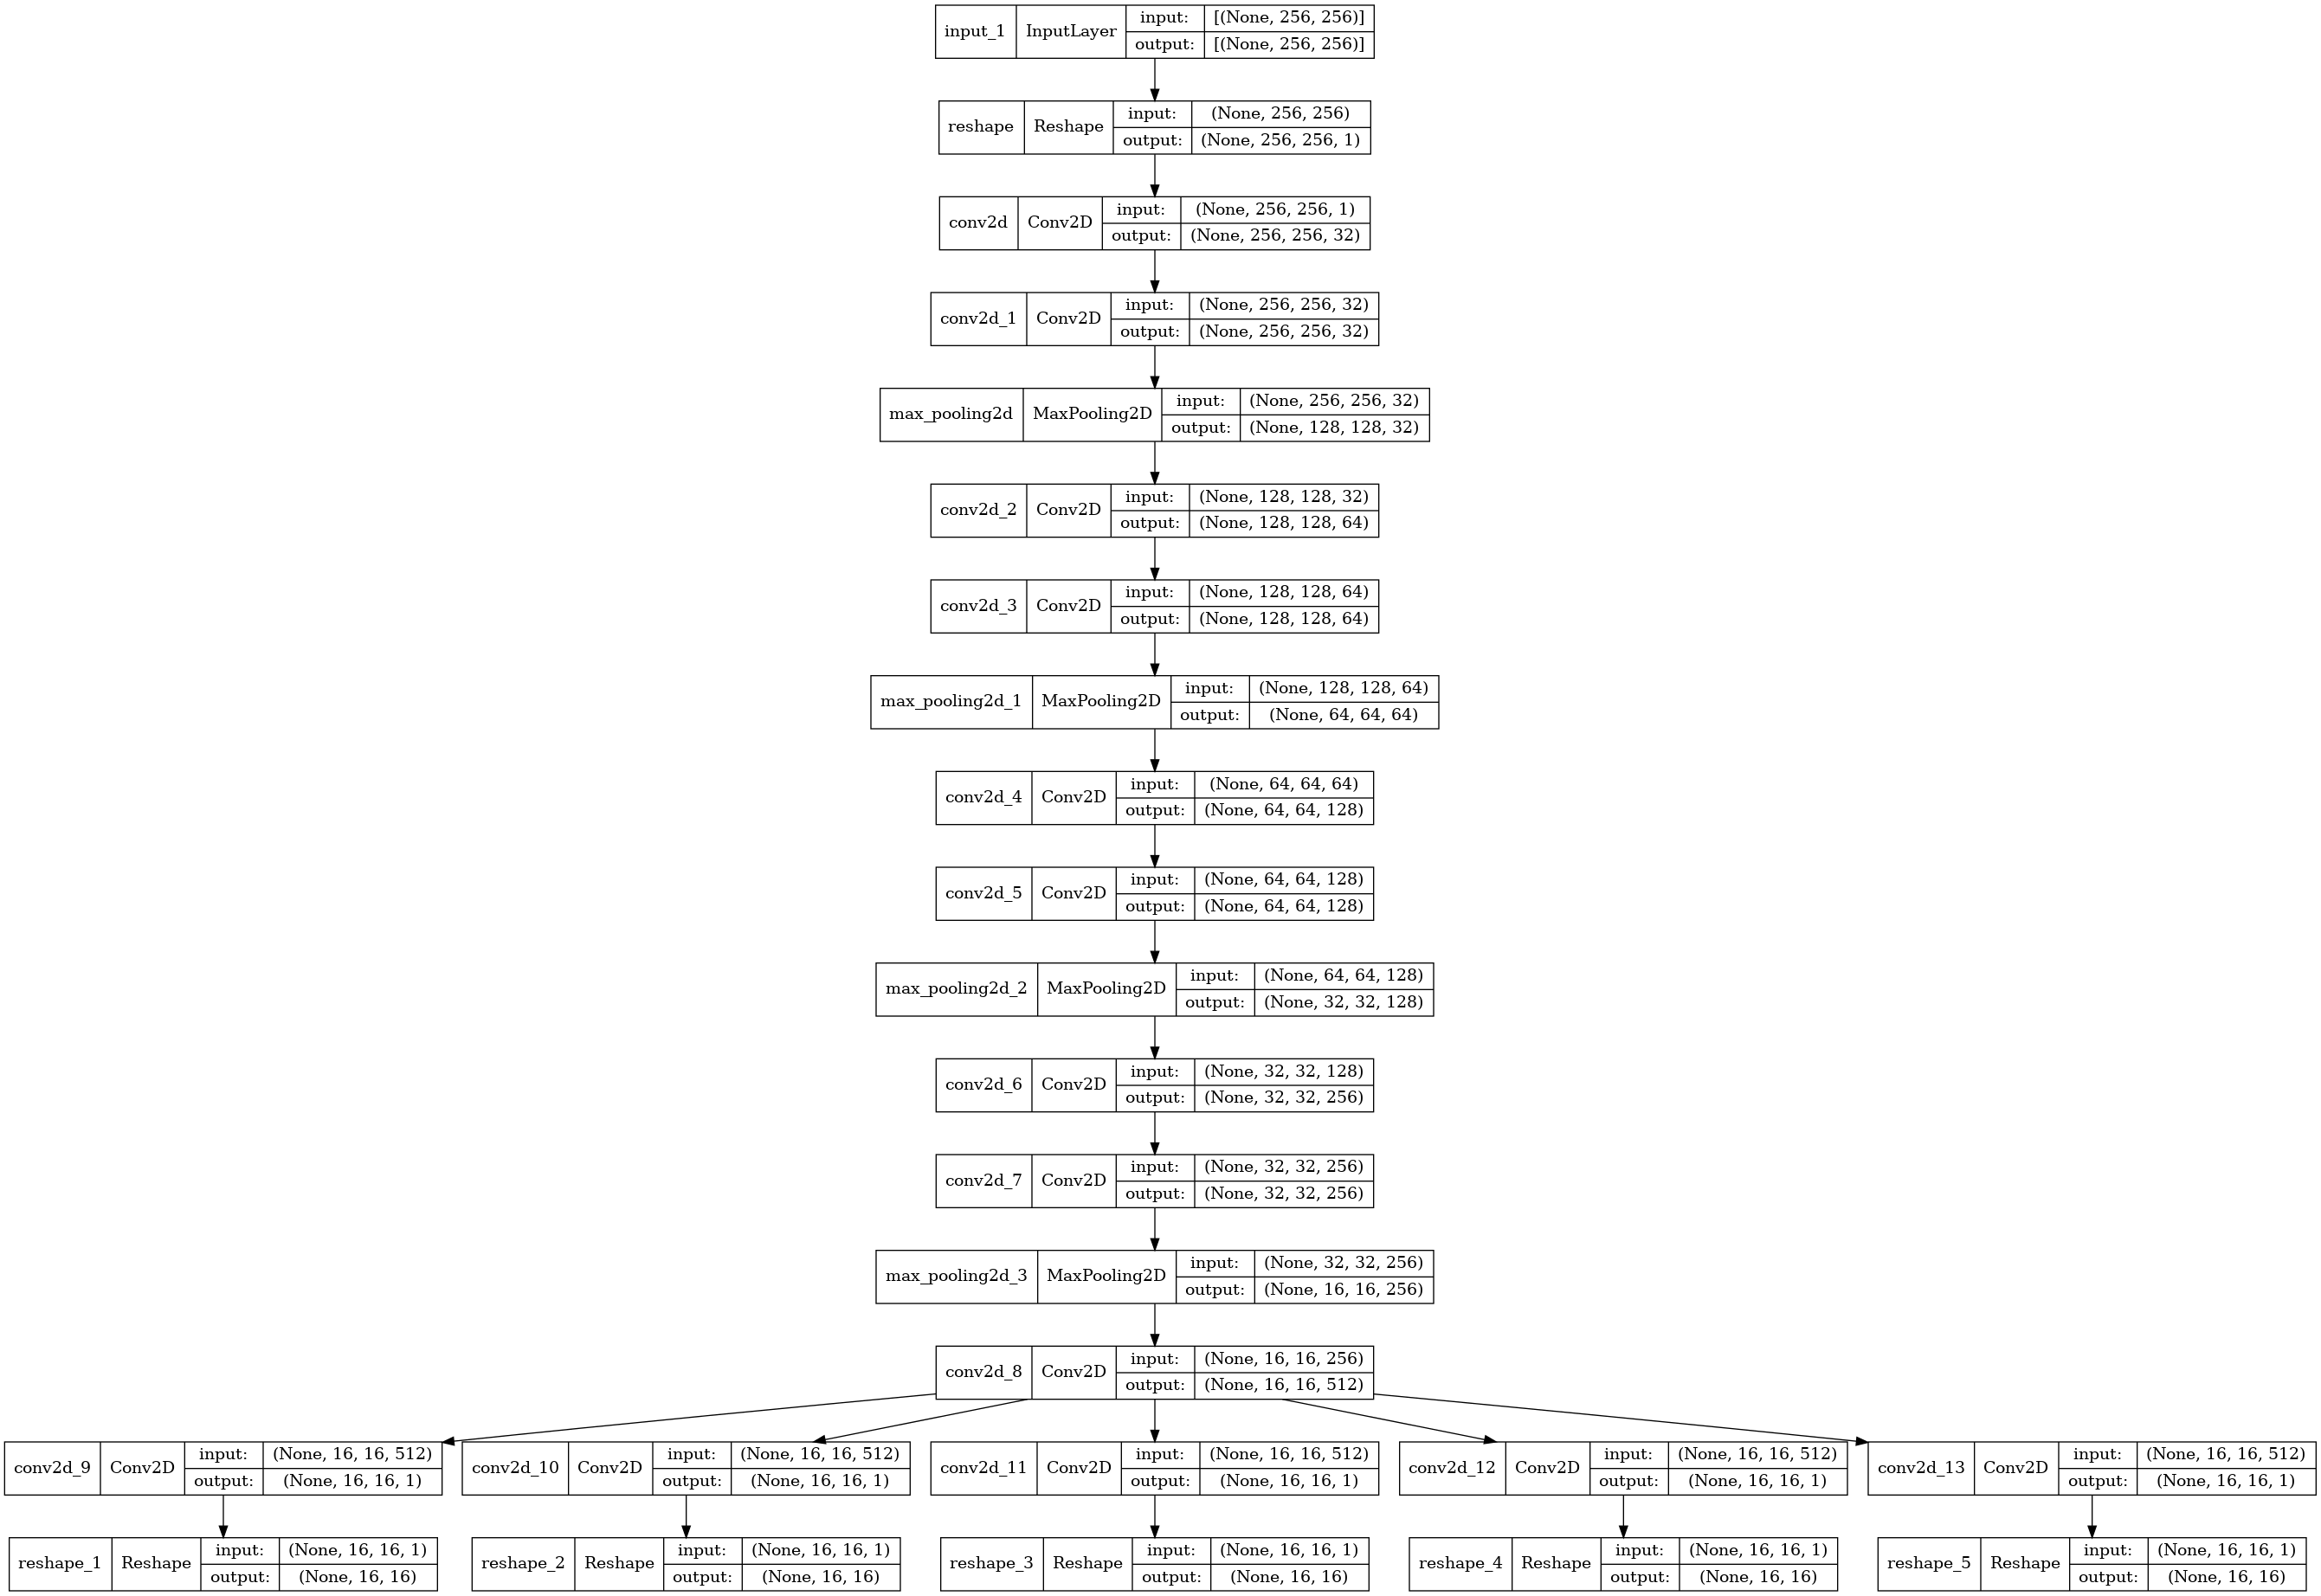

In [6]:
spectrum = tf.keras.Input([256, 256])
signal = tf.keras.layers.Reshape([256, 256, 1])(spectrum)
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(128, 128, 32)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(64, 64, 64)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(32, 32, 128)
signal = tf.keras.layers.Conv2D(256, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.Conv2D(256, 3, 1, 'same', activation = 'relu')(signal)
signal = tf.keras.layers.MaxPool2D()(signal) #(16, 16, 256)
signal = tf.keras.layers.Conv2D(512, 3, 1, 'same', activation = 'relu')(signal)
ob_logits = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
ob_logits = tf.keras.layers.Reshape([16, 16])(ob_logits)
sp_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
sp_shifts = tf.keras.layers.Reshape([16, 16])(sp_shifts)
fr_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
fr_shifts = tf.keras.layers.Reshape([16, 16])(fr_shifts)
dc_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
dc_shifts = tf.keras.layers.Reshape([16, 16])(dc_shifts)
am_shifts = tf.keras.layers.Conv2D(1, 3, 1, 'same')(signal)
am_shifts = tf.keras.layers.Reshape([16, 16])(am_shifts)
model = tf.keras.models.Model(spectrum, (ob_logits, sp_shifts, fr_shifts, dc_shifts, am_shifts))
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Load model weights.

In [7]:
model.load_weights('model/05extract.h5')

### Generated data
Random number of peaks from 1 to 9.

In [8]:
count = tf.random.uniform([], 1, 10, dtype = tf.int32)

Random objectness labels as 1 or 0 if a cell contains a peak or not and random peak parameters relative to each cell in range from 0 to 1.

In [9]:
ob_labels = tf.concat([tf.ones([count]), tf.zeros([sp_cells * fr_cells - count])], -1)
ob_labels = tf.random.shuffle(ob_labels)
ob_labels = tf.reshape(ob_labels, [sp_cells, fr_cells])

sp_shifts = tf.random.uniform([sp_cells, fr_cells])
fr_shifts = tf.random.uniform([sp_cells, fr_cells])
dc_shifts = tf.random.uniform([sp_cells, fr_cells])
am_shifts = tf.random.uniform([sp_cells, fr_cells])

Peak parameters relative to the entire grid in range from 0 to 1 and peak parameters in units used in experiment.

In [10]:
sp_units = (sp_offsets + sp_shifts) / sp_cells
fr_units = (fr_offsets + fr_shifts) / fr_cells
dc_units = dc_shifts
am_units = am_shifts

sp_values = sp_units * (sp_max - sp_min) + sp_min
fr_values = fr_units * (fr_max - fr_min) + fr_min
dc_values = dc_units * (dc_max - dc_min) + dc_min
am_values = am_units * (am_max - am_min) + am_min

Auxiliary arrays for generating spectrum in tensorflow.

In [11]:
t = tf.complex(tf.range(2 * fr_pixels, dtype = tf.float32) / fr_pixels / 2., 0.)
a = tf.range(series, dtype = tf.float32)
b = 2. * math.pi * \
    tf.complex(0., tf.range(dwmin, dwmax, (dwmax - dwmin) / sp_pixels, dtype = tf.float32))[:, None] * t

Spectrum.

In [12]:
f = a[:, None, None] * sp_values + fr_values + fr_pixels / 2.
fid = tf.complex(ob_labels * am_values, 0.) * \
      tf.exp(2. * math.pi * t[:, None, None, None] * (tf.complex(-dc_values, f))) * \
      tf.cast(tf.logical_and(0.8 * fr_pixels / 2. <= f, f <= 2. * fr_pixels - 0.8 * fr_pixels / 2.), tf.complex64)
fid = tf.reduce_sum(fid, [2, 3])
fid = tf.concat([fid[: 1] / 2., fid[1:]], 0)
p = tf.exp(-b[:, :, None] * tf.complex(a, 0.)) * fid
spectrum = tf.math.real(tf.signal.fft(tf.reduce_sum(p, 2)))[:, fr_pixels // 2 : 2 * fr_pixels - fr_pixels // 2]

Objectness labels and peak shifts from generator.

In [13]:
ob_labels0 = ob_labels.numpy()

sp_shifts0 = sp_shifts.numpy()
fr_shifts0 = fr_shifts.numpy()
dc_shifts0 = dc_shifts.numpy()
am_shifts0 = am_shifts.numpy()

Spectrum normalized to zero mean and unit variance as required by the model.

In [14]:
spectrum = (spectrum - 180.45589) / 217.40448

### Predicted data
Predicting objectness and peak parameters by passing the spectrum to the model.

In [15]:
ob_logits, sp_shifts, fr_shifts, dc_shifts, am_shifts = model(spectrum[None])

Objectness logits and labels from model.

In [16]:
ob_logits1 = ob_logits[0].numpy()
ob_labels1 = np.where(ob_logits1 < 0., 0., 1.)

Peak shifts from model.

In [17]:
sp_shifts1 = sp_shifts[0].numpy()
fr_shifts1 = fr_shifts[0].numpy()
dc_shifts1 = dc_shifts[0].numpy()
am_shifts1 = am_shifts[0].numpy()

Offsets of cells relative to the entire grid in range from 0 to the number of cells.

In [18]:
sp_offsets = sp_offsets.numpy()
fr_offsets = fr_offsets.numpy()

Peak parameters relative to the entire grid in range from 0 to 1.

In [19]:
sp_units0 = (sp_offsets + sp_shifts0) / sp_cells
sp_units1 = (sp_offsets + sp_shifts1) / sp_cells
fr_units0 = (fr_offsets + fr_shifts0) / fr_cells
fr_units1 = (fr_offsets + fr_shifts1) / fr_cells
dc_units0 = dc_shifts0
dc_units1 = dc_shifts1
am_units0 = am_shifts0
am_units1 = am_shifts1

Peak coordinates in pixels.

In [20]:
sp_cords0 = (sp_units0 * sp_pixels).astype(np.int32)
sp_cords1 = (sp_units1 * sp_pixels).astype(np.int32)
fr_cords0 = (fr_units0 * sp_pixels).astype(np.int32)
fr_cords1 = (fr_units1 * sp_pixels).astype(np.int32)

Spectrum normalized to range from 0 to 1 for plotting.

In [21]:
spectrum = spectrum.numpy()
spectrum = spectrum - spectrum.min()
spectrum = spectrum / spectrum.max()

### Ploting the tensorflow spectrum
Spectrum converted from grayscale to RGB.

In [22]:
spectrum = np.array([spectrum, spectrum, spectrum]).transpose((1, 2, 0))

Plot the grid in blue.

In [23]:
spectrum[16 * np.arange(16), :, 2] = 1.
spectrum[:, 16 * np.arange(16), 2] = 1.

Plot peaks from generator in green crosses.

In [24]:
for sp_cell in range(sp_cells):
    for fr_cell in range(fr_cells):
        if ob_labels0[sp_cell, fr_cell] > 0.5:
            spectrum[sp_cords0[sp_cell, fr_cell] + 0, fr_cords0[sp_cell, fr_cell] + 0, :] = [0., 1., 0.]
            spectrum[sp_cords0[sp_cell, fr_cell] - 1, fr_cords0[sp_cell, fr_cell] - 1, :] = [0., 1., 0.]
            spectrum[sp_cords0[sp_cell, fr_cell] - 1, fr_cords0[sp_cell, fr_cell] + 1, :] = [0., 1., 0.]
            spectrum[sp_cords0[sp_cell, fr_cell] + 1, fr_cords0[sp_cell, fr_cell] - 1, :] = [0., 1., 0.]
            spectrum[sp_cords0[sp_cell, fr_cell] + 1, fr_cords0[sp_cell, fr_cell] + 1, :] = [0., 1., 0.]

Plot peaks predicted by the model in red pluses.

In [25]:
for sp_cell in range(sp_cells):
    for fr_cell in range(fr_cells):
        if ob_labels1[sp_cell, fr_cell] > 0.5:
            spectrum[sp_cords1[sp_cell, fr_cell] + 0, fr_cords1[sp_cell, fr_cell] + 0, :] = [1., 0., 0.]
            spectrum[sp_cords1[sp_cell, fr_cell] + 0, fr_cords1[sp_cell, fr_cell] - 1, :] = [1., 0., 0.]
            spectrum[sp_cords1[sp_cell, fr_cell] + 0, fr_cords1[sp_cell, fr_cell] + 1, :] = [1., 0., 0.]
            spectrum[sp_cords1[sp_cell, fr_cell] - 1, fr_cords1[sp_cell, fr_cell] + 0, :] = [1., 0., 0.]
            spectrum[sp_cords1[sp_cell, fr_cell] + 1, fr_cords1[sp_cell, fr_cell] + 0, :] = [1., 0., 0.]

Display the spectrum with plotted grid and peaks

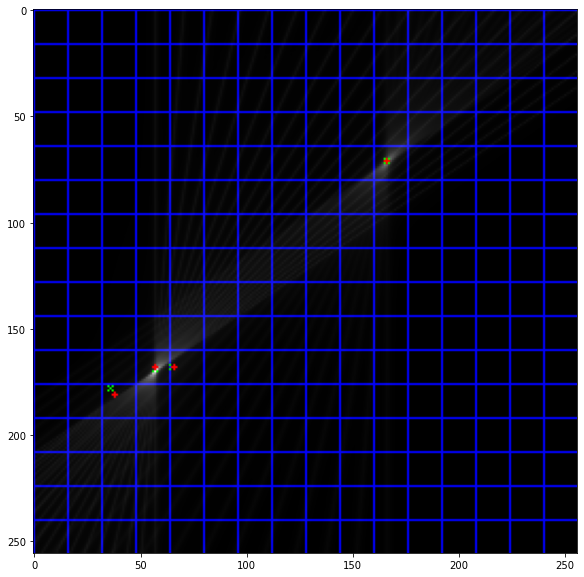

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(spectrum)
plt.show()